In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tokenizers import Tokenizer, models, pre_tokenizers, trainers, normalizers
import pandas as pd

from tensorflow.keras import mixed_precision as mixed_precision # Added 24052024
from tensorflow.keras.regularizers import l2


policy = mixed_precision.Policy('mixed_float16') # Added 24052024
mixed_precision.set_global_policy(policy) # 24052024

print(tf.__version__)

2024-05-31 14:00:32.669494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0
2.12.0


2024-05-31 14:00:40.437200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 14:00:40.472952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 14:00:40.473362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
!pip install tokenizers

  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached huggingface_hub-0.23.2-py3-none-any.whl.metadata (12 kB)
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
Using cached huggingface_hub-0.23.2-py3-none-any.whl (401 kB)


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from datetime import datetime

start = datetime.now()
print(start)

df_train = pd.read_csv('train.csv', delimiter =",", encoding='utf-8', encoding_errors=None)
df_train.head()

2024-05-31 14:00:49.096014


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [5]:
len(df_train)

17307

In [6]:
df_aug = df_train.copy(deep=True)
df_aug['full_text'] = np.NaN

In [7]:
print(df_aug)

      essay_id  full_text  score
0      000d118        NaN      3
1      000fe60        NaN      3
2      001ab80        NaN      4
3      001bdc0        NaN      4
4      002ba53        NaN      3
...        ...        ...    ...
17302  ffd378d        NaN      2
17303  ffddf1f        NaN      4
17304  fff016d        NaN      2
17305  fffb49b        NaN      1
17306  fffed3e        NaN      2

[17307 rows x 3 columns]


In [8]:
!pip install gensim

  Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)


In [9]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors

# Load pre-trained GloVe word vectors (you need to download the GloVe embeddings file beforehand)
glove_file = 'glove.6B.300d.txt'

print("Loading word vectors\n")
word_vectors = KeyedVectors.load_word2vec_format(fname = glove_file, binary=False, unicode_errors='ignore', no_header=True, limit=400000) # limit increased 30/05/2024
print("Word vectors loaded\n")

from tqdm import tqdm

print("Precomputing similar words\n")
similar_words_dict = {}
for word in word_vectors.index_to_key:
    similar_words_dict[word] = word_vectors.most_similar(word, topn=1)[0][0]
print("Precompute complete\n")    

# Define text augmentation function using GloVe embeddings
def augment_text_with_glove(text, similar_words_dict):
    augmented_text = []
    for word in text.split():
        if word in similar_words_dict:                        
            augmented_text.append(similar_words_dict[word])
        else:
            augmented_text.append(word)  # If the word is not in GloVe vocabulary, keep the original word
    return ' '.join(augmented_text)

print("Starting data augmentation now\n")
aug_start = datetime.now()
print("Augmentation start time is: ", aug_start)


# Apply text augmentation to the DataFrame
df_aug['full_text'] = df_train['full_text'].apply(lambda x: augment_text_with_glove(x, similar_words_dict))

aug_end = datetime.now()
print("\nAugmentation end time is: ", aug_end)
print("\nData augmentation complete")

Loading word vectors

Word vectors loaded

Precomputing similar words

Precompute complete

Starting data augmentation now

Augmentation start time is:  2024-05-31 14:01:02.026218

Augmentation end time is:  2024-05-31 14:01:04.631104

Data augmentation complete


In [10]:
df_train_fin = pd.concat([df_train, df_aug], axis=0)
len(df_train_fin)

34614

In [11]:
df_train_fin['score'] = df_train_fin['score'] - 1

In [12]:
df_train_fin['full_text'].map(len).mean()

2161.1192003235683

In [13]:
# !pip install --user spacy

In [14]:
# import spacy
# # Load the English tokenizer, tagger, parser, NER, and word vectors
# nlp = spacy.load("en_core_web_sm")

# # Function to apply lemmatization
# def lemmatize_text(text):
#     doc = nlp(text)
#     return " ".join([token.lemma_ for token in doc])

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit as sss

splits = sss(n_splits=1, test_size=0.1, random_state=0)

for train_index, test_index in splits.split(df_train_fin, df_train_fin['score']):
    train_set = df_train_fin.iloc[train_index]
    test_set = df_train_fin.iloc[test_index]

print("Train set indices:", train_set.index)
print("Test set indices:", test_set.index)

Train set indices: Index([ 3192,  8823, 12664, 16504, 15723,  2148,  8007, 12778,  9807,  3894,
       ...
        6321, 12451, 16183,  3397, 12600,  1648, 16623,  8339, 12384, 16059],
      dtype='int64', length=31152)
Test set indices: Index([13501,  5701, 15894, 10932,  9277,   670,  4056,  2064, 11066, 15971,
       ...
       10193, 11870,  7782, 17291, 16622,  6910, 14972, 13886,   757, 15115],
      dtype='int64', length=3462)


In [16]:
len(train_set)

31152

In [17]:
texts = train_set['full_text'].tolist()
labels = train_set['score'].tolist()

In [18]:
val_texts = test_set['full_text'].tolist()
val_labels = test_set['score'].tolist()

In [19]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, normalizers
# Initialize and train a BPE tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = normalizers.Sequence([normalizers.NFKC(), normalizers.Lowercase()])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=400000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]) # vocab size increased 30/05/2024
tokenizer.train_from_iterator(texts, trainer)
tokenizer.save("tokenizer.json")

In [20]:
# Load the trained tokenizer and tokenize the texts
tokenizer = Tokenizer.from_file("tokenizer.json")
tokenized_texts = [tokenizer.encode(text).ids for text in texts]

In [21]:
val_tokenized_texts = [tokenizer.encode(val_text).ids for val_text in val_texts]

In [22]:
# Pad the tokenized texts
max_length = 3000
padded_texts = pad_sequences(tokenized_texts, maxlen=max_length, padding='post')

val_padded_texts = pad_sequences(val_tokenized_texts, maxlen=max_length, padding='post')

In [23]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((padded_texts, labels))
dataset = dataset.shuffle(len(texts)).batch(256) # increased 28/05/2024

val_dataset = tf.data.Dataset.from_tensor_slices((val_padded_texts, val_labels))
val_dataset = val_dataset.shuffle(len(val_texts)).batch(256) # increased 28/05/2024

2024-05-31 14:01:58.499712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 14:01:58.500107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 14:01:58.500321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [63]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
tf.keras.layers.Input(shape=(max_length,)),
tf.keras.layers.Embedding(input_dim=400000, output_dim=128), # input dim increased 30/05/2024
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)), # added 28/05/2024
tf.keras.layers.Dropout(0.4), # added 28/05/2024
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),    
tf.keras.layers.GlobalMaxPooling1D(),
tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath = 'best_model.h5',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max',
    verbose=1)

2024-05-31 15:47:29.587184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 15:47:29.590053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 15:47:29.591919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 128)         51200000  
                                                                 
 conv1d (Conv1D)             (None, 2996, 128)         82048     
                                                                 
 dropout (Dropout)           (None, 2996, 128)         0         
                                                                 
 dense (Dense)               (None, 2996, 64)          8256      
                                                                 
 dropout_1 (Dropout)         (None, 2996, 64)          0         
                                                                 
 dense_1 (Dense)             (None, 2996, 64)          4160      
                                                                 
 dropout_2 (Dropout)         (None, 2996, 64)          0

2024-05-31 15:47:31.033954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-05-31 15:47:31.104842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 15:47:31.106807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [ ]:
tf.keras.backend.clear_session()

history = model.fit(dataset, epochs=40, validation_data=val_dataset, callbacks=[checkpoint_callback])

Epoch 1/40


2024-05-31 15:47:42.229315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 15:47:42.232119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 15:47:42.234727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

122/122 [==============================] - ETA: 0s - loss: 2.1036 - accuracy: 0.3601

2024-05-31 15:48:48.501594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 15:48:48.504086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 15:48:48.505933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.36366, saving model to best_model.h5
122/122 [==============================] - 77s 551ms/step - loss: 2.1036 - accuracy: 0.3601 - val_loss: 1.6025 - val_accuracy: 0.3637
Epoch 2/40
122/122 [==============================] - ETA: 0s - loss: 1.4228 - accuracy: 0.4092
Epoch 2: val_accuracy improved from 0.36366 to 0.40728, saving model to best_model.h5
122/122 [==============================] - 61s 499ms/step - loss: 1.4228 - accuracy: 0.4092 - val_loss: 1.3877 - val_accuracy: 0.4073
Epoch 3/40
122/122 [==============================] - ETA: 0s - loss: 1.2836 - accuracy: 0.4563
Epoch 3: val_accuracy improved from 0.40728 to 0.45869, saving model to best_model.h5
122/122 [==============================] - 57s 468ms/step - loss: 1.2836 - accuracy: 0.4563 - val_loss: 1.2613 - val_accuracy: 0.4587
Epoch 4/40
122/122 [==============================] - ETA: 0s - loss: 1.1689 - accuracy: 0.5042
Epoch 4: val_accuracy improved from 0.45869 to 0.48642

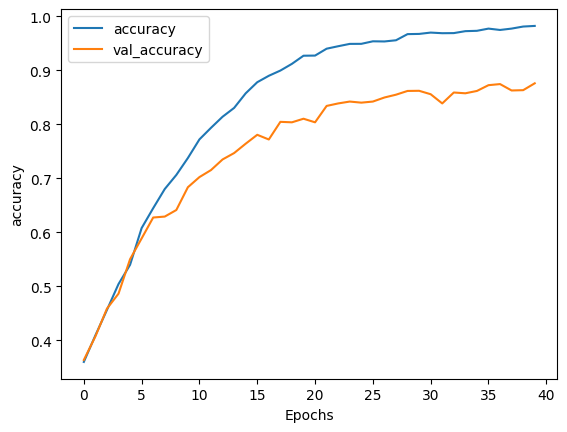

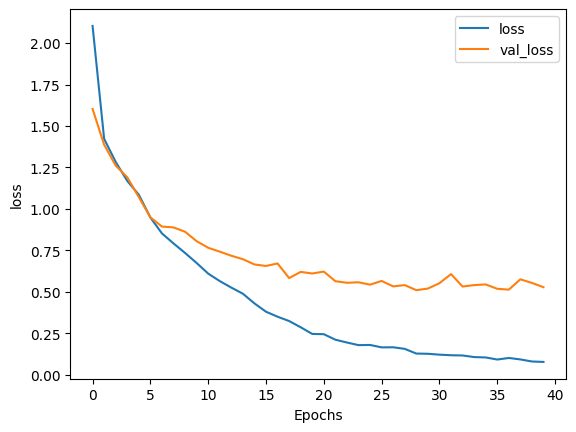

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
best_model = tf.keras.models.load_model('best_model.h5')

2024-05-31 16:21:24.892312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 16:21:24.894966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 16:21:24.897335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
df_test = pd.read_csv('test.csv')
df_test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [ ]:
pred_texts = df_test['full_text'].tolist()
tokenized_pred_texts = [tokenizer.encode(pred_text).ids for pred_text in pred_texts]
padded_pred_texts = pad_sequences(tokenized_pred_texts, maxlen=max_length, padding='post')
numpy_pred_texts = np.array(padded_pred_texts)

In [ ]:
preds = best_model.predict(numpy_pred_texts)
preds

2024-05-31 16:21:27.629854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 16:21:27.632521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 16:21:27.634532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step


array([[1.043e-05, 3.719e-03, 9.956e-01, 6.723e-04, 4.351e-06, 9.537e-07],
       [3.493e-05, 6.084e-03, 9.932e-01, 8.965e-04, 3.874e-06, 1.311e-06],
       [1.693e-05, 1.597e-04, 1.493e-03, 9.941e-01, 4.059e-03, 1.489e-04]],
      dtype=float16)

In [ ]:
max_preds = np.argmax(preds, axis=1)
res_lst = max_preds + 1
res_lst

array([3, 3, 4])

In [ ]:
df_sub = pd.DataFrame()
df_sub['essay_id'] = df_test['essay_id']
df_sub

,essay_id
0,000d118
1,000fe60
2,001ab80


In [ ]:
df_sub['score'] = res_lst.transpose()
df_sub['score'] = df_sub['score'].astype('int')
df_sub

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [ ]:
df_sub.to_csv('submission.csv', header=True, index=False)

In [ ]:
import gc

gc.collect()

end = datetime.now()
print(end)

2024-05-31 16:21:29.861830
